In [2]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import time
import numpy as np
from sys import getsizeof
from math import exp, log
import os

from cuckoofilter import CuckooFilter
from cuckoofilter import CountingBloomFilter

try:
    import seaborn as sns
    sns.set(context='notebook', style='darkgrid',  font='sans-serif', font_scale=1)
except ImportError: #proceed anyway even if user does not have seaborn. 
    pass

## False Positive Rate Comparison

In [5]:
def counting_bloom_and_cuckoo_filter_fpr(capacity, finger_print_size=0.5, bucket_size=4,\
                                         number_of_bytes=100000, alpha=0.75):
    #alpha = percent to fill the cuckoo filter. 
    #the finger print size is in bytes
    alpha = number_of_bytes / (capacity * finger_print_size * bucket_size)
    
    analytic_bloom_error = exp(-(((number_of_bytes-1)*log(2)**2)/capacity) ) 
    
    analytic_cuckoo_error = 1 / (2**( finger_print_size*alpha*8 - log(2*bucket_size, 2)))#this is estimated from the paper
    
    return analytic_bloom_error, analytic_cuckoo_error

In [12]:
capacities = [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7, 3e7]
bloom_fp = []
cuckoo_fp = []

for size in capacities:
    bfp, cfp = counting_bloom_and_cuckoo_filter_fpr(size, finger_print_size=0.5, bucket_size=4, alpha=0.8)
    bloom_fp.append(bfp)
    cuckoo_fp.append(cfp)

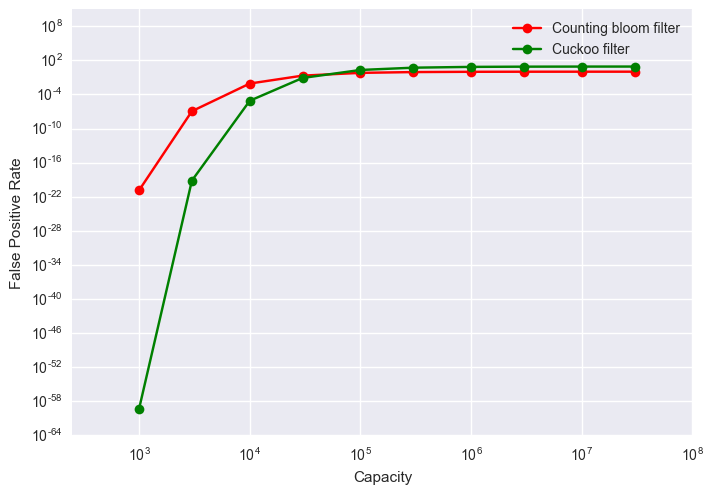

In [13]:
#result from running this once. takes more than 10mins, so not running multiple times. 
plt.loglog(np.array(capacities), np.array(bloom_fp), "-ro", ms=7, label="Counting bloom filter")
plt.loglog(np.array(capacities), np.array(cuckoo_fp), "-go", ms=7, label="Cuckoo filter")
plt.xlim([2.5*10e1, 10e7])
plt.ylim([10e-65, 10e10])
plt.ylabel("False Positive Rate")
plt.xlabel("Capacity")
plt.legend()
plt.savefig('images/false_positive_(0.1MB).png', bbox_inches='tight')

## Insertion

In [ ]:
def insert_and_time_filter_cuckoo_filter(capacity, percent_fill=0.9):
    num_inserted = 0
    c_filter = CuckooFilter(capacity, 2)
    now = time.time()
    for i in range(int(percent_fill*capacity)):
        try:
            c_filter.insert(str(i))
            num_inserted += 1
        except Exception("CuckooFilter has filled up!"):
            break
    elapsed_insertion = time.time() - now
    return c_filter, elapsed_insertion, num_inserted

In [ ]:
def insert_and_time_filter_bloom_filter(capacity, percent_fill=0.9):
    num_inserted = 0
    b_filter = CountingBloomFilter(capacity)
    now = time.time()
    for i in range(int(percent_fill*capacity)):
        b_filter.add(str(i))
    elapsed_insertion = time.time() - now
    return b_filter, elapsed_insertion

In [ ]:
item_sizes = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
bloom_times = []
cuckoo_times = []

In [ ]:
for size in item_sizes:
    
    __, c_time, num_inserted = insert_and_time_filter_cuckoo_filter(size)
    cuckoo_times.append(c_time)
    
    __,b_time =  insert_and_time_filter_bloom_filter(num_inserted)
    bloom_times.append(b_time)


In [ ]:
#result from running this once. takes more than 10mins, so not running multiple times. 
bloom_times = [0.0011990070343017578, 0.013823986053466797, 0.11611700057983398,\
               0.9570591449737549, 10.124736070632935, 104.50716304779053, 940.164537191391]
cuckoo_times = [0.00010991096496582031, 0.0009801387786865234, 0.00880289077758789,\
                0.06479001045227051, 1.1676461696624756, 7.817487001419067, 70.73717784881592]
plt.loglog(np.array(item_sizes), np.array(bloom_times), "-ro", ms=7, label="Counting bloom filter")
plt.loglog(np.array(item_sizes), np.array(cuckoo_times), "-go", ms=7, label="Cuckoo filter")
plt.xlim([5.0 * 10e-1, 10e7])
plt.ylim([5.0 * 10e-6, 10e4])
plt.ylabel("Time (seconds)")
plt.xlabel("Number of items inserted")
plt.title("Insertion Time")
plt.legend()
plt.savefig('images/insertion_time.pdf', bbox_inches='tight')

# Deletion

In [ ]:
item_sizes = [10, 100, 1000, 10000, 100000, 1000000]

def delete_from_cuckoo_filter_and_time(capacity, percent_to_fill=0.9, percent_delete=1.0):
    c_filter, _ = insert_and_time_filter_cuckoo_filter(capacity, percent_fill=percent_to_fill)
    
    total_size = c_filter.get_size()
    number_of_items_to_delete = total_size*percent_delete
    
    now = time.time()
    for i in range(int(number_of_items_to_delete)):
        c_filter.remove(str(i))
    elapsed_time = time.time() - now
        
    return c_filter, elapsed_time

In [ ]:
def delete_from_bloom_filter_and_time(capacity, percent_to_fill=0.9, percent_delete=1.0):
    b_filter, _ = insert_and_time_filter_bloom_filter(capacity, percent_fill=percent_to_fill)
    
    total_size = b_filter.get_size()
    number_of_items_to_delete = total_size*percent_delete
    
    now = time.time()
    for i in range(int(number_of_items_to_delete)):
        b_filter.remove(str(i))
    elapsed_time = time.time() - now
        
    return b_filter, elapsed_time

In [ ]:
delete_from_cuckoo_filter_and_time(100, percent_to_fill=0.9, percent_delete=1.0)

In [ ]:
delete_from_bloom_filter_and_time(100, percent_to_fill=0.9, percent_delete=1.0)

In [ ]:
bloom_times_deletion = []
cuckoo_times_deletion = []

In [ ]:
for size in item_sizes:
    __,b_time =  delete_from_bloom_filter_and_time(size, percent_to_fill=0.9, percent_delete=1.0)
    bloom_times_deletion.append(b_time)
    
    __, c_time = delete_from_cuckoo_filter_and_time(size, percent_to_fill=0.9, percent_delete=1.0)
    cuckoo_times_deletion.append(c_time)

In [ ]:
plt.loglog(np.array(item_sizes), np.array(bloom_times_deletion), "-ro", ms=7, label="Counting bloom filter")
plt.loglog(np.array(item_sizes), np.array(cuckoo_times_deletion), "-go", ms=7, label="Cuckoo filter")
plt.xlim([5.0 * 10e-1, 10e7])
plt.ylim([10e-6, 10e2])
plt.ylabel("Time (seconds)")
plt.xlabel("Number of items Deleted")
plt.title("Deletion Time")
plt.legend()
plt.savefig('images/deletion_time.pdf', bbox_inches='tight')

# Size of the filters

In [ ]:
bloom_file_size = []
cuckoo_file_size = []
set_file_size = []

item_sizes = [10, 100, 1000, 10000, 100000, 1000000]
for size in item_sizes:
    b_filter = CountingBloomFilter(size, error=0.05598)
    bloom_file_size.append(b_filter.number_of_bytes())
    cuckoo_file_size.append(2*size) #if you use a fingerprint size of 2 bytes
    set_file_size.append(55*size)

In [ ]:
plt.loglog(np.array(item_sizes), np.array(bloom_file_size)/1000, "-ro", ms=7, label="Counting bloom filter")
plt.loglog(np.array(item_sizes), np.array(cuckoo_file_size)/1000, "-go", ms=7, label="Cuckoo filter")
plt.loglog(np.array(item_sizes), np.array(set_file_size)/1000, "-bo", ms=7, label="Set")
plt.xlim([5.0 * 10e-1, 10e7])
plt.ylim([10e-3, 0.8*10e6])
plt.ylabel("Amount of space used (kilobytes)")
plt.xlabel("Number of items")
plt.title("Memory use across the different data structures")
plt.legend()
plt.savefig('images/file_size.pdf', bbox_inches='tight')